In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

class CustomDataLoader:
    def __init__(self, features, labels, batch_size=1, validation_size=0.0, shuffle=False):
        if validation_size > 0:
            train_data, val_data, train_labels, val_labels = train_test_split(features, labels, test_size=validation_size, random_state=42)
            self.train_loader = DataLoader(TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels).float()), batch_size=batch_size, shuffle=shuffle)
            self.val_loader = DataLoader(TensorDataset(torch.tensor(val_data).float(), torch.tensor(val_labels).float()), batch_size=batch_size, shuffle=shuffle)
        else:
            self.train_loader = DataLoader(TensorDataset(torch.tensor(features).float(), torch.tensor(labels).float()), batch_size=batch_size, shuffle=shuffle)
            self.val_loader = None

    def get_train_loader(self):
        return self.train_loader

    def get_val_loader(self):
        return self.val_loader

def evaluate_model(model, custom_train_loader, criterion, optimizer):
    num_epochs = 1200
    parameters = []
    image_folder = 'training_images'
    os.makedirs(image_folder, exist_ok=True)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in custom_train_loader.get_train_loader():
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.view(-1, 3))
            loss = criterion(outputs, labels.view(-1, 1))

            if torch.isnan(loss):
                print("Loss is NaN or Inf")
                print(parameters)

                for name, param in model.named_parameters():
                    print(f"{name}: {param}")
                break

            parameters = []
            for name, param in model.named_parameters():
                parameters.append(f"{name}: {param}")

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_train_loss = running_loss / len(custom_train_loader.get_train_loader())
            
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in custom_train_loader.get_val_loader():
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.view(-1, 3))
                val_loss = criterion(outputs, labels.view(-1, 1))
                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(custom_train_loader.get_val_loader())
        print(f"Epoch {epoch+1:4d} | Train Loss: {avg_train_loss} | Validation Loss: {avg_val_loss}")

        num = 10000
        
        columns = []
        
        x = np.linspace(-6, 6, num).reshape(-1, 1)
        y = np.linspace(-0, 0, num)
        random_feature1 = np.linspace(-0, 0, num)
        random_feature2 = np.linspace(-0, 0, num)

        for bias in biases:
            column = x + 0
            columns.append(column)
        columns.append(y)
        columns.append(random_feature1)
        
        inputs = np.column_stack(columns)
        inputs_tensor = torch.from_numpy(inputs).float().to(device)

        model.eval()
        with torch.no_grad():
            y_pred_model = model(inputs_tensor).cpu().numpy()

        a = x
        y_pred_manual = np.sin(a) + 2 * np.cos(a + 3 * np.sin(a)) + 3 * np.cos(a) ** 2 * np.sin(a) ** 2 + 0.5 * np.cos(a)
        
        plt.figure(figsize=(10, 5))
        plt.scatter(x, y_pred_model.flatten(), label='Model Output', s=1, alpha=0.1)
        plt.scatter(x, y_pred_manual, label='Manual Calculation', s=1, alpha=0.1)
        plt.xlabel('Input Feature 1')
        plt.ylabel('Output')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{image_folder}/epoch_{epoch+1:04d}.png")
        plt.close()

    images = []
    for epoch in range(num_epochs):
        filename = f"{image_folder}/epoch_{epoch+1:04d}.png"
        images.append(imageio.imread(filename))
    imageio.mimsave('training_progress.gif', images, duration=0.2)

In [6]:
import numpy as np
num_samples = 128 * 100
import math

a = (np.random.rand(num_samples, 1) - 0.5) * 4
b = (np.random.rand(num_samples, 1) - 0.5) * 4
c = (np.random.rand(num_samples, 1) - 0.5) * 4
d = (np.random.rand(num_samples, 1) - 0.5) * 4
e = (np.random.rand(num_samples, 1) - 0.5) * 4

const = 1
const_array = np.full((num_samples, 1), const)

columns = []
biases = []

a = (np.random.rand(num_samples, 1) - 0.5) * 12
b = np.random.choice([0, 1], size=(num_samples, 1))

for _ in range(1):
    bias = np.random.uniform(-1, 1) 
    biases.append(bias)
    column = a + 0
    columns.append(column)

columns.append(b)
columns.append(c)
biases = np.array(biases)

x_train = np.column_stack(columns)
y_train = np.abs(a)
y_train = np.sin(a) + 2 * np.cos(a + 3 * np.sin(a)) + 3 * np.cos(a) ** 2 * np.sin(a) ** 2 + 0.5 * np.cos(a)
y_train = a * (1 / (1 + np.exp(-b)))
y_train = np.where(b == 1, a*c, a*c)

custom_train_loader = CustomDataLoader(x_train, y_train, batch_size=128, validation_size=0.2, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class CustomLinearLayer(nn.Module):
    def __init__(self, input_size, output_size, init_zero=False, split_inputs=False):
        super(CustomLinearLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=True)
        
        if init_zero:
            nn.init.zeros_(self.linear.weight)
            nn.init.zeros_(self.linear.bias)
        elif split_inputs:
            self.split_inputs()
            nn.init.uniform_(self.linear.bias, a=-10, b=10)
        else:
            self.custom_weight_init()
            nn.init.zeros_(self.linear.bias)

    def custom_weight_init(self):
        with torch.no_grad():
            rows, cols = self.linear.weight.size()
            weight = torch.zeros(rows, cols)
            for i in range(min(rows, cols) // 2):
                weight[2 * i, 2 * i] = 1
                weight[2 * i, 2 * i + 1] = -1
                if 2 * i + 1 < rows and 2 * i + 1 < cols:
                    weight[2 * i + 1, 2 * i] = -1
                    weight[2 * i + 1, 2 * i + 1] = 1
            self.linear.weight.copy_(weight)
            nn.init.zeros_(self.linear.bias)
            
    def split_inputs(self):
        weight = torch.zeros((self.linear.out_features, self.linear.in_features))
        
        for i in range(self.linear.out_features):
            if i % 2 == 0:
                weight[i, (i // 2) % self.linear.in_features] = 1
            else:
                weight[i, (i - 1) // 2 % self.linear.in_features] = -1
        
        self.linear.weight = nn.Parameter(weight)

    def forward(self, x):
        return self.linear(x)

In [361]:
class PairwiseCustomActivationNetwork(nn.Module):
    def __init__(self, input_size, num_layers, output_size):
        super(PairwiseCustomActivationNetwork, self).__init__()
        self.layer1 = CustomLinearLayer(input_size, input_size * 2 * 256 , init_zero=False, split_inputs=True)
#         self.layer2 = CustomLinearLayer(input_size * 2, input_size * 2 * 8)
        self.layer2 = CustomLinearLayer(input_size * 2 * 256, 1, init_zero=True)
#         self.num_layers = num_layers
#         self.layers = nn.ModuleList()
#         self.res_layers = nn.ModuleList()
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        
#         self.res_layers.append(CustomLinearLayer(input_size, input_size * 2, init_zero=False, split_inputs=True))
#         self.layers.append(CustomLinearLayer(input_size * 2, 1))

#         layer_size = input_size * 2
#         self.res_layers.append(CustomLinearLayer(input_size, input_size * 2, init_zero=False, split_inputs=True))
#         self.layers.append(CustomLinearLayer(layer_size, layer_size))
        
#         for i in range(1, num_layers):
#             layer_size += input_size
#             self.res_layers.append(CustomLinearLayer(input_size, input_size, init_zero=False, split_inputs=True))
#             self.layers.append(CustomLinearLayer(layer_size, layer_size))
            
#         layer_size += input_size * 2
#         self.res_layers.append(CustomLinearLayer(input_size, input_size * 2, init_zero=False, split_inputs=True))
#         self.layers.append(CustomLinearLayer(layer_size, output_size, init_zero=True))

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x
#         original = x
#         outputs = []
        
#         for i, (layer, res_layer) in enumerate(zip(self.layers, self.res_layers)):
#             outputs.append(res_layer(original))            
#             concatenated_outputs = torch.cat(outputs, dim=1)

#             if i != len(self.layers) - 1:
#                 outputs = [self.relu(layer(concatenated_outputs))]
#             else:
#                 outputs = [layer(concatenated_outputs)]
                
#         return outputs[0]
    
model = PairwiseCustomActivationNetwork(3, 1, 1).to(device)
criterion = nn.MSELoss()
print(summary(model, input_size=(1, 3)))

Layer (type:depth-idx)                   Output Shape              Param #
PairwiseCustomActivationNetwork          [1, 1]                    --
├─CustomLinearLayer: 1-1                 [1, 1536]                 --
│    └─Linear: 2-1                       [1, 1536]                 6,144
├─ReLU: 1-2                              [1, 1536]                 --
├─CustomLinearLayer: 1-3                 [1, 1]                    --
│    └─Linear: 2-2                       [1, 1]                    1,537
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04


In [347]:
for name, param in model.named_parameters():
    print(name, param)

layer1.linear.weight Parameter containing:
tensor([[ 1.,  0.,  0.],
        [-1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0., -1.]], device='cuda:0', requires_grad=True)
layer1.linear.bias Parameter containing:
tensor([-7.6015, -9.0671,  9.7433,  7.5915, -7.0549,  9.0111], device='cuda:0',
       requires_grad=True)
layer2.linear.weight Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0', requires_grad=True)
layer2.linear.bias Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)


In [98]:
model.eval()

input_vector = [0.01, 0, 0.5]
input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0).to(device)
useless_var = np.where(b == 1, a**2, -a + c)

with torch.no_grad():
    output = model(input_tensor)
    print(output)

tensor([[0.0023]], device='cuda:0')


In [55]:
class PairwiseCustomActivationNetwork(nn.Module):
    def __init__(self, input_size, num_layers, output_size):
        super(PairwiseCustomActivationNetwork, self).__init__()

        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.res_layers = nn.ModuleList()
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

        layer_size = input_size * 2
        self.res_layers.append(CustomLinearLayer(input_size, input_size * 2, init_zero=False, split_inputs=True))
        self.layers.append(CustomLinearLayer(layer_size, layer_size))
        
        for i in range(1, num_layers):
            layer_size *= 2
            self.res_layers.append(CustomLinearLayer(input_size, input_size, init_zero=False, split_inputs=True))
            self.layers.append(CustomLinearLayer(layer_size, layer_size))
            
        layer_size *= 2
        self.res_layers.append(CustomLinearLayer(input_size, input_size * 2, init_zero=False, split_inputs=True))
        self.layers.append(CustomLinearLayer(layer_size, output_size, init_zero=True))

    def forward(self, x):
        original = x
        outputs = [self.res_layers[0](original)]
        
        for i, (layer, res_layer) in enumerate(zip(self.layers, self.res_layers)):
#             outputs.append(res_layer(original))            
            concatenated_outputs = torch.cat(outputs, dim=1)
            
            if i != len(self.layers) - 1:
                outputs.append(self.softplus(layer(concatenated_outputs)))
            else:
                outputs.append(layer(concatenated_outputs))
                
                
        return outputs[-1]
    
model = PairwiseCustomActivationNetwork(3, 8, 1).to(device)
criterion = nn.MSELoss()
print(summary(model, input_size=(1, 3)))


Layer (type:depth-idx)                   Output Shape              Param #
PairwiseCustomActivationNetwork          [1, 1]                    --
├─ModuleList: 1-1                        --                        108
│    └─CustomLinearLayer: 2-1            [1, 6]                    --
│    │    └─Linear: 3-1                  [1, 6]                    24
├─ModuleList: 1-18                       --                        (recursive)
│    └─CustomLinearLayer: 2-2            [1, 6]                    --
│    │    └─Linear: 3-2                  [1, 6]                    42
├─Softplus: 1-3                          [1, 6]                    --
├─ModuleList: 1-18                       --                        (recursive)
│    └─CustomLinearLayer: 2-3            [1, 12]                   --
│    │    └─Linear: 3-3                  [1, 12]                   156
├─Softplus: 1-5                          [1, 12]                   --
├─ModuleList: 1-18                       --                      

In [64]:
optimizer = optim.Adam(model.parameters(), lr=0.00000000001 * 1 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss: 4.1761359352676666e-05 | Validation Loss: 3.729847758222604e-05
Epoch    2 | Train Loss: 4.1761397687878345e-05 | Validation Loss: 3.729848094735644e-05
Epoch    3 | Train Loss: 4.1761377383409125e-05 | Validation Loss: 3.729846666828962e-05
Epoch    4 | Train Loss: 4.176138486400305e-05 | Validation Loss: 3.729852642209153e-05
Epoch    5 | Train Loss: 4.176135346369847e-05 | Validation Loss: 3.7298500592442e-05
Epoch    6 | Train Loss: 4.176135205398168e-05 | Validation Loss: 3.7298545248631856e-05
Epoch    7 | Train Loss: 4.1761335432966006e-05 | Validation Loss: 3.7298547613318076e-05
Epoch    8 | Train Loss: 4.176133068085619e-05 | Validation Loss: 3.7298540883057284e-05
Epoch    9 | Train Loss: 4.1761336251511236e-05 | Validation Loss: 3.729858863152913e-05
Epoch   10 | Train Loss: 4.176132949851308e-05 | Validation Loss: 3.7298549796105365e-05
Epoch   11 | Train Loss: 4.17613283616447e-05 | Validation Loss: 3.729859936356661e-05
Epoch   12 | Train Loss: 4

KeyboardInterrupt: 

In [63]:
optimizer = optim.Adam(model.parameters(), lr=0.00000000001 * 1 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss: 4.178831743502087e-05 | Validation Loss: 3.730434282260831e-05
Epoch    2 | Train Loss: 4.1773178804760394e-05 | Validation Loss: 3.730439875653247e-05


KeyboardInterrupt: 

In [62]:
optimizer = optim.Adam(model.parameters(), lr=0.00000001 * 1 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss: 4.2122242371078754e-05 | Validation Loss: 3.74700440261222e-05
Epoch    2 | Train Loss: 4.2075319515788576e-05 | Validation Loss: 3.7516467909881615e-05
Epoch    3 | Train Loss: 4.205076124890184e-05 | Validation Loss: 3.748949820874259e-05
Epoch    4 | Train Loss: 4.2070693166351705e-05 | Validation Loss: 3.7535088904405714e-05
Epoch    5 | Train Loss: 4.20531376676081e-05 | Validation Loss: 3.7411842004075877e-05
Epoch    6 | Train Loss: 4.198151807486283e-05 | Validation Loss: 3.745267640624661e-05
Epoch    7 | Train Loss: 4.2055803669427404e-05 | Validation Loss: 3.7423850972118086e-05
Epoch    8 | Train Loss: 4.1970083702835834e-05 | Validation Loss: 3.750649993889965e-05
Epoch    9 | Train Loss: 4.194904599899019e-05 | Validation Loss: 3.746868278540205e-05
Epoch   10 | Train Loss: 4.2001351425824394e-05 | Validation Loss: 3.750391097128159e-05
Epoch   11 | Train Loss: 4.2038283299916654e-05 | Validation Loss: 3.7423305820993845e-05
Epoch   12 | Train Los

KeyboardInterrupt: 

In [61]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 1 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss: 4.932251197260484e-05 | Validation Loss: 4.361703377071535e-05
Epoch    2 | Train Loss: 4.8983513920575206e-05 | Validation Loss: 4.3390861446823695e-05
Epoch    3 | Train Loss: 4.8545198706051454e-05 | Validation Loss: 4.35760786785977e-05
Epoch    4 | Train Loss: 4.917875296541752e-05 | Validation Loss: 4.342070560596767e-05
Epoch    5 | Train Loss: 4.854464261825342e-05 | Validation Loss: 4.280488747099298e-05
Epoch    6 | Train Loss: 4.8651249130671204e-05 | Validation Loss: 4.35042457866075e-05
Epoch    7 | Train Loss: 4.848064788802731e-05 | Validation Loss: 4.36342121247435e-05
Epoch    8 | Train Loss: 4.856405762438953e-05 | Validation Loss: 4.2978250712621956e-05
Epoch    9 | Train Loss: 4.818977872673713e-05 | Validation Loss: 4.326902899265406e-05
Epoch   10 | Train Loss: 4.8746057086646036e-05 | Validation Loss: 4.6133692740113476e-05
Epoch   11 | Train Loss: 4.8721323310019216e-05 | Validation Loss: 4.2605574708431956e-05
Epoch   12 | Train Loss: 4

KeyboardInterrupt: 

In [60]:
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss: 6.701514566884726e-05 | Validation Loss: 5.68784489587415e-05
Epoch    2 | Train Loss: 6.500484996649903e-05 | Validation Loss: 5.715572806366254e-05
Epoch    3 | Train Loss: 6.379183457738691e-05 | Validation Loss: 5.5473074098699726e-05
Epoch    4 | Train Loss: 6.350125613607815e-05 | Validation Loss: 6.164491078379797e-05
Epoch    5 | Train Loss: 6.316885774140246e-05 | Validation Loss: 5.6925460376078264e-05
Epoch    6 | Train Loss: 6.201987080203252e-05 | Validation Loss: 5.212621672399109e-05
Epoch    7 | Train Loss: 6.206905261478824e-05 | Validation Loss: 8.119083031488117e-05
Epoch    8 | Train Loss: 6.365746876326738e-05 | Validation Loss: 5.104621159262024e-05
Epoch    9 | Train Loss: 6.050487695574702e-05 | Validation Loss: 5.765892346971668e-05
Epoch   10 | Train Loss: 6.210598685356672e-05 | Validation Loss: 5.255053056316683e-05
Epoch   11 | Train Loss: 6.258985183649202e-05 | Validation Loss: 5.6532952839916106e-05
Epoch   12 | Train Loss: 5.996

KeyboardInterrupt: 

In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 100 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:    15.9797 | Validation Loss:    15.3399
Epoch    2 | Train Loss:    15.1251 | Validation Loss:    13.6970
Epoch    3 | Train Loss:    12.2845 | Validation Loss:     9.7600
Epoch    4 | Train Loss:     7.9866 | Validation Loss:     6.2009
Epoch    5 | Train Loss:     5.4810 | Validation Loss:     4.5194
Epoch    6 | Train Loss:     4.1037 | Validation Loss:     3.4443
Epoch    7 | Train Loss:     3.1998 | Validation Loss:     2.7696
Epoch    8 | Train Loss:     2.6114 | Validation Loss:     2.3114
Epoch    9 | Train Loss:     2.2190 | Validation Loss:     2.0217
Epoch   10 | Train Loss:     1.9521 | Validation Loss:     1.8221
Epoch   11 | Train Loss:     1.7594 | Validation Loss:     1.6778
Epoch   12 | Train Loss:     1.6032 | Validation Loss:     1.5311
Epoch   13 | Train Loss:     1.4597 | Validation Loss:     1.3871
Epoch   14 | Train Loss:     1.3325 | Validation Loss:     1.2605
Epoch   15 | Train Loss:     1.2078 | Validation Loss:     1.1481
Epoch   16

KeyboardInterrupt: 

In [57]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 10 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    2 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    3 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    4 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    5 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    6 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    7 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    8 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch    9 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   10 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   11 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   12 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   13 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   14 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   15 | Train Loss:     0.0001 | Validation Loss:     0.0001
Epoch   16

KeyboardInterrupt: 

In [54]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 100 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:    16.0331 | Validation Loss:    15.5599
Epoch    2 | Train Loss:    16.0332 | Validation Loss:    15.5571
Epoch    3 | Train Loss:    16.0341 | Validation Loss:    15.5662
Epoch    4 | Train Loss:    16.0464 | Validation Loss:    15.5801
Epoch    5 | Train Loss:    16.0263 | Validation Loss:    15.5635
Epoch    6 | Train Loss:    16.0488 | Validation Loss:    15.5995
Epoch    7 | Train Loss:    16.0297 | Validation Loss:    15.5734
Epoch    8 | Train Loss:    16.0246 | Validation Loss:    15.5519
Epoch    9 | Train Loss:    15.9835 | Validation Loss:    15.4684
Epoch   10 | Train Loss:    15.7837 | Validation Loss:    15.1572
Epoch   11 | Train Loss:    15.1635 | Validation Loss:    14.2238
Epoch   12 | Train Loss:    13.1517 | Validation Loss:    10.8894
Epoch   13 | Train Loss:     8.8288 | Validation Loss:     6.5896
Epoch   14 | Train Loss:     5.6189 | Validation Loss:     4.9263
Epoch   15 | Train Loss:     4.7493 | Validation Loss:     4.6685
Epoch   16

KeyboardInterrupt: 

In [ ]:
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:     0.0067 | Validation Loss:     0.0068
Epoch    2 | Train Loss:     0.0076 | Validation Loss:     0.0069
Epoch    3 | Train Loss:     0.0072 | Validation Loss:     0.0066
Epoch    4 | Train Loss:     0.0069 | Validation Loss:     0.0066
Epoch    5 | Train Loss:     0.0071 | Validation Loss:     0.0080
Epoch    6 | Train Loss:     0.0090 | Validation Loss:     0.0060
Epoch    7 | Train Loss:     0.0074 | Validation Loss:     0.0057
Epoch    8 | Train Loss:     0.0064 | Validation Loss:     0.0060
Epoch    9 | Train Loss:     0.0065 | Validation Loss:     0.0059
Epoch   10 | Train Loss:     0.0063 | Validation Loss:     0.0071
Epoch   11 | Train Loss:     0.0061 | Validation Loss:     0.0071
Epoch   12 | Train Loss:     0.0069 | Validation Loss:     0.0078
Epoch   13 | Train Loss:     0.0069 | Validation Loss:     0.0072
Epoch   14 | Train Loss:     0.0064 | Validation Loss:     0.0056
Epoch   15 | Train Loss:     0.0066 | Validation Loss:     0.0071
Epoch   16

In [364]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 1000 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:    16.2018 | Validation Loss:    15.6782
Epoch    2 | Train Loss:    16.1983 | Validation Loss:    15.6765
Epoch    3 | Train Loss:    16.1977 | Validation Loss:    15.6730
Epoch    4 | Train Loss:    16.1967 | Validation Loss:    15.6714
Epoch    5 | Train Loss:    16.1919 | Validation Loss:    15.6658
Epoch    6 | Train Loss:    16.1776 | Validation Loss:    15.6321
Epoch    7 | Train Loss:    16.1310 | Validation Loss:    15.5671
Epoch    8 | Train Loss:    15.9455 | Validation Loss:    15.2049
Epoch    9 | Train Loss:    14.8920 | Validation Loss:    13.2720
Epoch   10 | Train Loss:    11.9144 | Validation Loss:     9.7941
Epoch   11 | Train Loss:     9.1096 | Validation Loss:     7.6368
Epoch   12 | Train Loss:     7.5952 | Validation Loss:     6.5399
Epoch   13 | Train Loss:     6.6632 | Validation Loss:     5.6619
Epoch   14 | Train Loss:     5.7258 | Validation Loss:     4.5282
Epoch   15 | Train Loss:     3.9493 | Validation Loss:     2.4194
Epoch   16

KeyboardInterrupt: 

In [362]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 1000 * 1)
evaluate_model(model, custom_train_loader, criterion, optimizer)

Epoch    1 | Train Loss:    16.3214 | Validation Loss:    15.7638
Epoch    2 | Train Loss:    16.2479 | Validation Loss:    15.6506
Epoch    3 | Train Loss:    16.2096 | Validation Loss:    15.6601
Epoch    4 | Train Loss:    16.0590 | Validation Loss:    15.4282
Epoch    5 | Train Loss:    15.7726 | Validation Loss:    15.0790
Epoch    6 | Train Loss:    15.2782 | Validation Loss:    14.6372
Epoch    7 | Train Loss:    14.6292 | Validation Loss:    13.7000
Epoch    8 | Train Loss:    13.6994 | Validation Loss:    12.8070
Epoch    9 | Train Loss:    12.6405 | Validation Loss:    11.7299
Epoch   10 | Train Loss:    11.4711 | Validation Loss:    10.5386
Epoch   11 | Train Loss:    10.1810 | Validation Loss:     9.3904
Epoch   12 | Train Loss:     8.8768 | Validation Loss:     7.9216
Epoch   13 | Train Loss:     7.5419 | Validation Loss:     6.7129
Epoch   14 | Train Loss:     6.2650 | Validation Loss:     5.4831
Epoch   15 | Train Loss:     5.0917 | Validation Loss:     4.5048
Epoch   16

KeyboardInterrupt: 

Epoch    1 | Train Loss:    13.2357 | Validation Loss:     7.5224
Epoch    2 | Train Loss:     4.8987 | Validation Loss:     2.9569
Epoch    3 | Train Loss:     2.9797 | Validation Loss:     2.3361
Epoch    4 | Train Loss:     2.4879 | Validation Loss:     1.9432
Epoch    5 | Train Loss:     2.0585 | Validation Loss:     1.5535
Epoch    6 | Train Loss:     1.6818 | Validation Loss:     1.2518
Epoch    7 | Train Loss:     1.4028 | Validation Loss:     1.0520
Epoch    8 | Train Loss:     1.2043 | Validation Loss:     0.9144
Epoch    9 | Train Loss:     1.0586 | Validation Loss:     0.8148
Epoch   10 | Train Loss:     0.9475 | Validation Loss:     0.7359
Epoch   11 | Train Loss:     0.8605 | Validation Loss:     0.6722
Epoch   12 | Train Loss:     0.7930 | Validation Loss:     0.6380
Epoch   13 | Train Loss:     0.7366 | Validation Loss:     0.6010
Epoch   14 | Train Loss:     0.6900 | Validation Loss:     0.5699
Epoch   15 | Train Loss:     0.6568 | Validation Loss:     0.5475
Epoch   16

KeyboardInterrupt: 

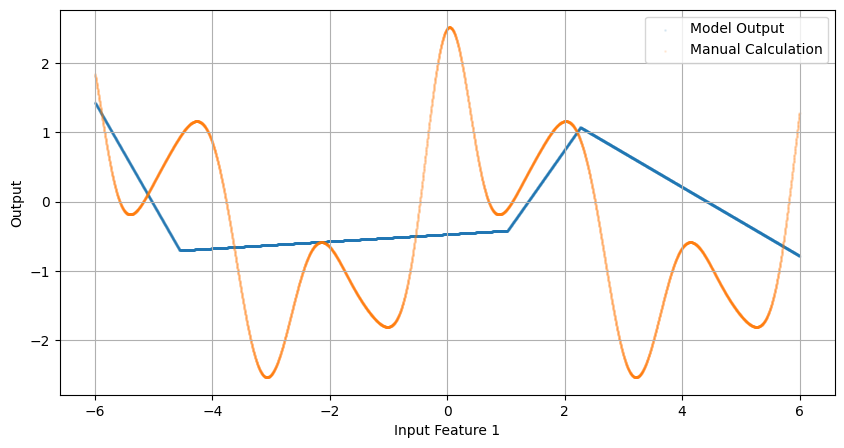

In [316]:
optimizer = optim.Adam(model.parameters(), lr=0.0000001 * 1000 * 100)
evaluate_model(model, custom_train_loader, criterion, optimizer)